In [56]:
!pip list

Package                            Version
---------------------------------- ---------------------
absl-py                            1.4.0
aiohttp                            3.9.5
aiosignal                          1.3.1
alabaster                          0.7.16
albumentations                     1.3.1
alembic                            1.13.2
altair                             4.2.2
aniso8601                          9.0.1
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.15.1
astropy                            5.3.4
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              23.2.0
audioread                          3.0.1
autograd                           1.6.2
Babel                            

# Home Work

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mlflow

In [3]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

В этой работе будем иследовать одну из популярнейших рекомендательных моделей - **Latent Factor Model** - https://arxiv.org/pdf/1912.04754.

Перед выполнением задания нужно убедиться, что прогоняется бейзлайн. Для этого:

1) Скачайте  файлы - **node2name.json** и **clickstream.parque** с необходимыми данными

2) Положите в репозиторий ноутбука и запустите код

В этой работе вам нужно:
1) перебрать параметры модели - edim,batch_size, lr, epoch , num_negatives -   (по **1 балу - 5 балов**)

2) Тип OPTIMIZER_NAME - (**4 бала за 5 оптимизаторов**)

3) На основе имеющихся данных собрать лучшую модель (по **precision@30**) и рассчитать ее метрики (**4 бала**)

4) Попробовать другие модели (например  als - https://benfred.github.io/implicit/ , gru4rec, sasrec  ) - за sasrec на хорошем уровне сразу **10 балов**. За другие модели по **3 бала**

5) По окончанию работы в mlflow настроить графики для сравнения моделей. Можно проявить фантазию, но обязательно должно быть сравнение с бейзлайном (данный ноутбук) против других моделей

6) В mlflow залогировать последнюю версию ноутбука - необходимое условия. Либо в github, но тогда прикрепить ссылку в [mlflow](http://84.201.128.89:90/) . Эксперимент в формате - **homework-\<name\>**

7) Доп балы (**20 баллов**) тому у кого будет наибольший скор на тесте. Но ваш ноутбук должен прогонятся и быть вопроизводимым.

Суммарно за работу **20 балов**

In [4]:
main_path = '/content/drive/MyDrive/ml_system_design_logging'

In [5]:
import json

with open(f'{main_path}/node2name.json', 'r') as f:
    node2name = json.load(f)

node2name = {int(k):v for k,v in node2name.items()}


In [6]:
# node2name

In [7]:
import pandas as pd

df = pd.read_parquet(f'{main_path}/clickstream.parque')
df = df.head(100_000)


In [8]:
df['is_train'] = df['event_date']< df['event_date'].max() - pd.Timedelta('2 day')
df['names'] = df['node_id'].map(node2name)

In [9]:
df

,cookie_id,event_date,node_id,is_train,names
0,15157399,2024-02-21 11:20:01,1047840,True,root -> Транспорт -> Запчасти и аксессуары -> ...
1,15157399,2024-03-05 10:24:54,1047561,True,root -> Услуги -> Предложения услуг -> Красота...
2,15157399,2024-03-05 10:28:55,1047561,True,root -> Услуги -> Предложения услуг -> Красота...
3,15157399,2024-04-13 11:22:25,1047835,True,root -> Транспорт -> Запчасти и аксессуары -> ...
4,15157399,2024-04-13 11:22:45,1047835,True,root -> Транспорт -> Запчасти и аксессуары -> ...
...,...,...,...,...,...
99995,20324089388,2024-04-06 20:22:13,1114510,True,"root -> Личные вещи -> Одежда, обувь, аксессуа..."
99996,20324089388,2024-04-06 20:24:20,1114510,True,"root -> Личные вещи -> Одежда, обувь, аксессуа..."
99997,20324089388,2024-04-06 20:27:25,1114510,True,"root -> Личные вещи -> Одежда, обувь, аксессуа..."
99998,20324089388,2024-04-06 20:33:10,1114510,True,"root -> Личные вещи -> Одежда, обувь, аксессуа..."


In [10]:
train_cooks = df[df['is_train']]['cookie_id'].unique()
train_items = df[df['is_train']]['node_id'].unique()


df = df[(df['cookie_id'].isin(train_cooks)) & (df['node_id'].isin(train_items))]


In [11]:
user_indes, index2user_id = pd.factorize(df['cookie_id'])
df['user_index'] = user_indes

node_indes, index2node = pd.factorize(df['node_id'])
df['node_index'] = node_indes


<ipython-input-11-aa381203fec3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_index'] = user_indes
<ipython-input-11-aa381203fec3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['node_index'] = node_indes


In [12]:
df['node_index'].max()

2175

In [13]:
df

,cookie_id,event_date,node_id,is_train,names,user_index,node_index
0,15157399,2024-02-21 11:20:01,1047840,True,root -> Транспорт -> Запчасти и аксессуары -> ...,0,0
1,15157399,2024-03-05 10:24:54,1047561,True,root -> Услуги -> Предложения услуг -> Красота...,0,1
2,15157399,2024-03-05 10:28:55,1047561,True,root -> Услуги -> Предложения услуг -> Красота...,0,1
3,15157399,2024-04-13 11:22:25,1047835,True,root -> Транспорт -> Запчасти и аксессуары -> ...,0,2
4,15157399,2024-04-13 11:22:45,1047835,True,root -> Транспорт -> Запчасти и аксессуары -> ...,0,2
...,...,...,...,...,...,...,...
99995,20324089388,2024-04-06 20:22:13,1114510,True,"root -> Личные вещи -> Одежда, обувь, аксессуа...",1663,212
99996,20324089388,2024-04-06 20:24:20,1114510,True,"root -> Личные вещи -> Одежда, обувь, аксессуа...",1663,212
99997,20324089388,2024-04-06 20:27:25,1114510,True,"root -> Личные вещи -> Одежда, обувь, аксессуа...",1663,212
99998,20324089388,2024-04-06 20:33:10,1114510,True,"root -> Личные вещи -> Одежда, обувь, аксессуа...",1663,212


In [14]:
df_train, df_test = df[df['is_train']], df[~df['is_train']]
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


df_train.shape, df_test.shape

((96611, 7), (3333, 7))

In [15]:
import torch
from torch import nn
import random
from tqdm.auto import tqdm

from torch.utils.data import Dataset, DataLoader


class RecDataset(Dataset):
    def __init__(self, users, items, item_per_users):
        self.users = users
        self.items = items
        self.item_per_users=item_per_users

    def __len__(self):
        return len(self.users)

    def __getitem__(self, i):
        user = self.users[i]
        return torch.tensor(user), torch.tensor(self.items[i]), self.item_per_users[user]


class LatentFactorModel(nn.Module):
    def __init__(self, edim, user_indexes, node_indexes):
        super(LatentFactorModel, self).__init__()
        self.edim = edim
        self.users = nn.Embedding(max(user_indexes) + 1, edim)
        self.items = nn.Embedding(max(node_indexes) + 1, edim)

    def forward(self, users, items):
        user_embedings = self.users(users).reshape(-1, self.edim )
        item_embedings = self.items(items)
        res = torch.einsum('be,bne->bn', user_embedings, item_embedings)
        return res

    def pred_top_k(self, users, K=10):
        user_embedings = self.users(users).reshape(-1, self.edim )
        item_embedings = self.items.weight
        res = torch.einsum('ue,ie->ui', user_embedings, item_embedings)
        return torch.topk(res, K, dim=1)




def collate_fn(batch, num_negatives, num_items):
    users, target_items, users_negatives = [],[], []
    for triplets in batch:
        user, target_item, seen_item = triplets

        users.append(user)
        target_items.append(target_item)
        user_negatives = []

        while len(user_negatives)< num_negatives:
            candidate = random.randint(0, num_items)
            if candidate not in seen_item:
                user_negatives.append(candidate)

        users_negatives.append(user_negatives)


    positive = torch.ones(len(batch), 1)
    negatives = torch.zeros(len(batch), num_negatives)
    labels = torch.hstack([positive, negatives])
    # print(torch.tensor(target_items))
    # print(users_negatives)
    items = torch.hstack([torch.tensor(target_items).reshape(-1, 1), torch.tensor(users_negatives)])
    return torch.hstack(users), items, labels



In [16]:
user2seen = df_train.groupby('user_index')['node_index'].agg(lambda x: list(set(x)))

# 1.1 Baseline

In [17]:
BATCH_SIZE = 50_000
NUM_NEGATIVES = 5
EDIM = 128
EPOCH = 10
OPTIMIZER_NAME = 'Adam'
LR = 1

train_dataset = RecDataset(df_train['user_index'].values, df_train['node_index'], user2seen)


dataloader = DataLoader(train_dataset, shuffle=True,num_workers=0, batch_size=BATCH_SIZE,collate_fn=lambda x: collate_fn(x, NUM_NEGATIVES, max(df['node_index'].values)))


model = LatentFactorModel(EDIM, user_indes, node_indes)
optimizer = torch.optim.Adam(model.parameters(), LR)

bar = tqdm(total = EPOCH)


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
for i in range(EPOCH):
    bar_loader = tqdm(total = len(dataloader) ,)
    losses = []
    for i in dataloader:
        users, items, labels = i
        optimizer.zero_grad()
        logits = model(users, items)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(
            logits, labels
        )
        loss.backward()
        optimizer.step()
        bar_loader.update(1)
        bar_loader.set_description(f'batch loss - {loss.item()}')
        losses.append(loss.item())

    bar.update(1)
    bar.set_description(f'epoch loss - {sum(losses)/len(losses)}')


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
USER = 0

preds = list(model.pred_top_k(torch.tensor([USER]), 10)[1][0].numpy())
df[(df['user_index'] == USER) & (df['node_index'].isin(user2seen[USER]))]['names'].tolist()

['root -> Транспорт -> Запчасти и аксессуары -> Запчасти -> Для автомобилей -> Кузов',
 'root -> Услуги -> Предложения услуг -> Красота, здоровье -> СПА-услуги, массаж',
 'root -> Услуги -> Предложения услуг -> Красота, здоровье -> СПА-услуги, массаж',
 'root -> Транспорт -> Запчасти и аксессуары -> Запчасти -> Для автомобилей -> Система охлаждения',
 'root -> Транспорт -> Запчасти и аксессуары -> Запчасти -> Для автомобилей -> Система охлаждения',
 'root -> Транспорт -> Запчасти и аксессуары -> Запчасти -> Для автомобилей -> Система охлаждения']

In [19]:
[node2name[index2node[i]] for i in preds]

['root -> Животные -> Кошки -> Шотландская',
 'root -> Личные вещи -> Одежда, обувь, аксессуары -> Аксессуары -> Галстуки и бабочки',
 'root -> Личные вещи -> Детская одежда и обувь -> Для девочек -> Пиджаки и костюмы',
 'root -> Транспорт -> Запчасти и аксессуары -> Шины, диски и колёса -> Диски -> 22 -> Литые -> 6x',
 'root -> Транспорт -> Грузовики и спецтехника -> Погрузчики -> Амкодор',
 'root -> Готовый бизнес и оборудование -> Оборудование для бизнеса -> Торговое -> Павильоны и фудтраки',
 'root -> Работа -> Вакансии -> Без опыта, студенты -> Сменный график',
 'root -> Готовый бизнес и оборудование -> Оборудование для бизнеса -> Пищевое -> Нейтральное -> Зонты вытяжные',
 'root -> Транспорт -> Запчасти и аксессуары -> Шины, диски и колёса -> Колёса -> 15 -> Литые -> Зимние нешипованные',
 'root -> Для дома и дачи -> Ремонт и строительство -> Инструменты -> Измерительные инструменты']

In [20]:
def calc_hitrate(df_preds, K):
    return  df_preds[df_preds['rank']<K].groupby('user_index')['relevant'].max().mean()

def calc_prec(df_preds, K):
    return  (df_preds[df_preds['rank']<K].groupby('user_index')['relevant'].mean()).mean()

In [21]:
import torch
import pandas as pd

def evaluate_model(model, df_test=df_test, K=100):
    test_users = df_test['user_index'].unique()

    preds = model.pred_top_k(torch.tensor(test_users), K)[1].numpy()


    test_users = df_test['user_index'].unique()

    df_preds = pd.DataFrame({
        'node_index': list(preds),
        'user_index': test_users,
        'rank': [[j for j in range(0, K)] for i in range(len(preds))]
    })

    df_preds = df_preds.explode(['node_index', 'rank']).merge(
        df_test[['user_index', 'node_index']].assign(relevant=1).drop_duplicates(),
        on = ['user_index', 'node_index'],
        how='left' ,
    )
    df_preds['relevant'] = df_preds['relevant'].fillna(0)


    # Расчет метрик
    hitrate = calc_hitrate(df_preds, K)
    precision = calc_prec(df_preds, 30)

    return hitrate, precision


In [22]:
hitrate, precision = evaluate_model(model)
print(f"Hitrate: {hitrate}, Precision: {precision}")

Hitrate: 0.10344827586206896, Precision: 0.0009495252373813095


In [23]:
params = {
    'batch_size': BATCH_SIZE,
    'num_negatives': NUM_NEGATIVES,
    'edim': EDIM,
    'epoch': EPOCH,
    'optimizer': OPTIMIZER_NAME,
    'lr': LR,
}

In [24]:
params

{'batch_size': 50000,
 'num_negatives': 5,
 'edim': 128,
 'epoch': 10,
 'optimizer': 'Adam',
 'lr': 1}

In [25]:
import mlflow

mlflow.set_tracking_uri('http://84.201.128.89:90/')

name_experiment = 'homework-ivlomonosov'

def log_data(name_experiment: str, params: dict = None, name: str = None):

  mlflow.set_experiment(name_experiment)

  if params:
    params_strs = [f'{k}={v}' for k, v in params.items()]
    final_name = '_'.join(params_strs)

  if not params and not name:
    raise ValueError('Name is required in non params cases!')

  run = name if name else final_name

  with mlflow.start_run(run_name=run):
      mlflow.log_metrics(
          {
              'precision_30': precision,
              'hitrate_100': hitrate,
          }
      )
      mlflow.log_params(
          {
          'model_name': run,
          }
      )

      if params:
        for param, value in params.items():
            mlflow.log_param(param, value)


In [ ]:
log_data(name_experiment, params, 'baseline')

# 1.2 Baseline (top popular)

In [ ]:
df_train['node_index'].max()

2175

In [25]:
K = 100

top_popular = df_train[['node_index']].assign(v=1).groupby('node_index').count().reset_index().sort_values(by='v').tail(K)['node_index'].values

In [26]:
node2name[index2node[top_popular[-1]]]

'root -> Транспорт -> Автомобили -> Внедорожник'

In [28]:
test_users = df_test['user_index'].unique()

df_preds_top_poplular = pd.DataFrame({'node_index': [list(top_popular) for i in test_users], 'user_index': test_users, 'rank': [[j for j in range(0, K)]for i in range(len(test_users))]})


df_preds_top_poplular = df_preds_top_poplular.explode(
    ['node_index', 'rank']
).merge(
    df_test[['user_index', 'node_index']].assign(relevant=1).drop_duplicates(),
    on = ['user_index', 'node_index'],
    how='left' ,
)
df_preds_top_poplular['relevant'] = df_preds_top_poplular['relevant'].fillna(0)

hitrate = calc_hitrate(df_preds_top_poplular, K)
precision = calc_prec(df_preds_top_poplular, 30)

In [29]:
precision, hitrate

(0.006796601699150424, 0.6836581709145427)

In [44]:
log_data(name_experiment, name='baseline_popular')

# 2. Experiments

## 2.1 Main params

In [ ]:
# Определение фиксированных значений для большинства параметров
fixed_params = {
  'batch_size': 50000,
  'num_negatives': 5,
  'edim': 128,
  'epoch': 10,
  'optimizer': 'Adam',
  'lr': 1
}

# Определение списка значений для варьируемого параметра
variable_params = {
    'edim': [64, 128, 256, 512],
    'batch_size': [1000, 10_000, 25_000, 50_000, 75_000, 100_000],
    'lr': [0.001, 0.01, 0.1, 1, 5, 10, 25],
    'epoch': [5, 10, 15, 50],
    'num_negatives': [5, 10, 15, 20],
    'optimizer': ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'AdamW'],
}

# Функция для генерации комбинаций, варьируя один параметр за раз
def generate_param_combinations(fixed_params, variable_params):
    all_combinations = []
    for key, values in variable_params.items():
        for value in values:
            params = fixed_params.copy()
            params[key] = value
            all_combinations.append(params)
    return all_combinations

param_combinations = generate_param_combinations(fixed_params, variable_params)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_and_evaluate_model(params, df_train, df_test, user2seen, node_indexes):
    batch_size = params['batch_size']
    num_negatives = params['num_negatives']
    edim = params['edim']
    epochs = params['epoch']
    optimizer_name = params['optimizer']
    lr = params['lr']

    train_dataset = RecDataset(df_train['user_index'].values, df_train['node_index'], user2seen)
    dataloader = DataLoader(train_dataset, shuffle=True, num_workers=0, batch_size=batch_size, collate_fn=lambda x: collate_fn(x, num_negatives, max(df_train['node_index'].values)))
    model = LatentFactorModel(edim, df_train['user_index'].values, node_indexes).to(device)


    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr)
    loss_fn = nn.BCEWithLogitsLoss()

    model.train()
    bar = tqdm(total=epochs)
    for epoch in range(epochs):
        bar_loader = tqdm(total=len(dataloader))
        losses = []
        for i, data in enumerate(dataloader):
            users, items, labels = data
            users, items, labels = users.to(device), items.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(users, items)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, labels)
            loss.backward()
            optimizer.step()
            bar_loader.update(1)
            bar_loader.set_description(f'batch loss - {loss.item()}')
            losses.append(loss.item())
        bar_loader.close()
        bar.update(1)
        bar.set_description(f'epoch loss - {sum(losses)/len(losses)}')
    bar.close()

    model.eval()
    model.to('cpu')
    hitrate, precision = evaluate_model(model)

    return precision, hitrate

# Цикл для перебора всех комбинаций параметров
best_precision = 0
best_params = None

for params in param_combinations:
    print(f"Testing params: {params}")
    precision, hitrate = train_and_evaluate_model(params, df_train, df_test, user2seen, df_train['node_index'].values)
    log_data(name_experiment, params=params)

    if precision > best_precision:
        best_precision = precision
        best_params = params
    print(f"Params: {params}, Precision@30: {precision}")

print(f"Best Precision@30: {best_precision} with params: {best_params}")


### Final Result

1. **Лучшая Precision@30: ~0.0468** с параметрами:
   - `batch_size`: 50000
   - `num_negatives`: 5
   - `edim`: 128
   - `epoch`: 10
   - `optimizer`: Adagrad
   - `lr`: 1

   После перебора гиперпараметров стало ясно, что решающую роль сыграл оптимизатор при использовании базовой модели.

2. **Если зафиксировать оптимизатор (Adam)**, то самым влиятельным параметром оказывается `num_negatives`, см. рисунок ниже.

3. **Этот подход к подбору гиперпараметров** не самый эффективный. Давайте попробуем использовать Optuna для оптимизации.



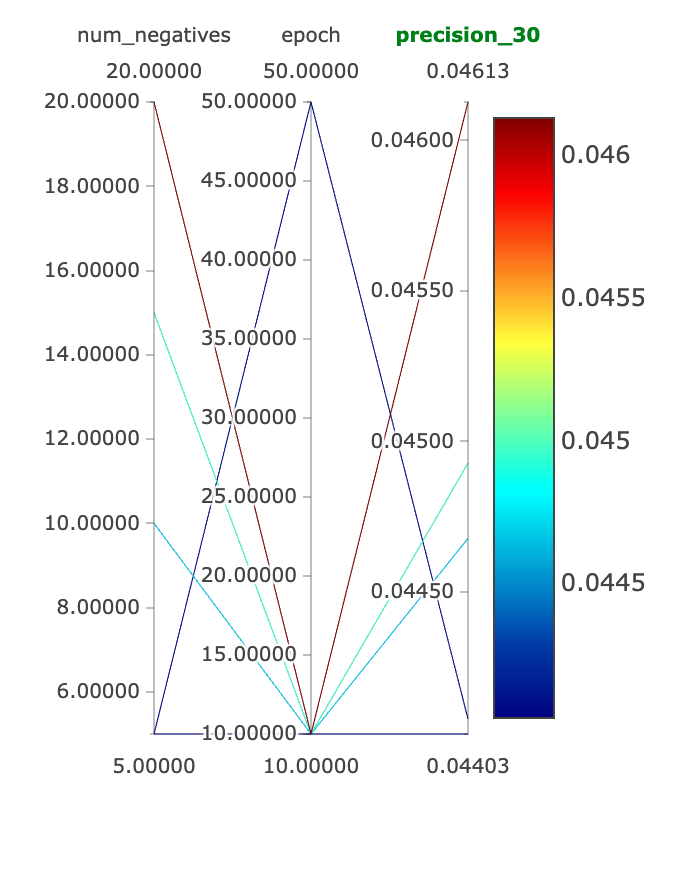

## 2.2 Use optuna
Поробуем более удачный подход. Отдельно посмотрим на основные параметры и оптимизаторы.

### Params

In [26]:
!pip install optuna

In [33]:
model_name = 'LFM'

In [37]:
def objective(trial):
    BATCH_SIZE = trial.suggest_categorical("batch_size", [100, 500, 1000, 5000, 10000, 50000, 100000])
    NUM_NEGATIVES = trial.suggest_int("num_negatives", 1, 20)
    EDIM = trial.suggest_categorical("edim", [32, 64, 128, 256, 512])
    EPOCH = trial.suggest_int("epoch", 5, 20,)
    LR = trial.suggest_float("lr", 1e-5, 1e+1, log=True)

    train_dataset = RecDataset(df_train['user_index'].values, df_train['node_index'], user2seen)
    dataloader = DataLoader(train_dataset, shuffle=True,num_workers=0, batch_size=BATCH_SIZE,collate_fn=lambda x: collate_fn(x, NUM_NEGATIVES, max(df['node_index'].values)))


    model = LatentFactorModel(EDIM, user_indes, node_indes)
    optimizer = torch.optim.Adam(model.parameters(), LR)


    for i in range(EPOCH):
        losses = []
        for i in dataloader:
            users, items, labels = i
            optimizer.zero_grad()
            logits = model(users, items)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(
                logits, labels
            )
            loss.backward()
            optimizer.step()
            losses.append(loss.item())


    K = 100
    test_users = df_test['user_index'].unique()

    preds = model.pred_top_k(torch.tensor(test_users), K)[1].numpy()
    df_preds = pd.DataFrame({'node_index': list(preds),
                             'user_index': test_users,
                             'rank': [[j for j in range(0, K)]for i in range(len(preds))]})

    df_preds = df_preds.explode(['node_index', 'rank']).merge(
        df_test[['user_index', 'node_index']].assign(relevant=1).drop_duplicates(),
        on = ['user_index', 'node_index'],
        how='left' ,
    )
    df_preds['relevant'] = df_preds['relevant'].fillna(0)

    precision = calc_prec(df_preds, 30)
    hitrate = calc_hitrate(df_preds, 100)

    final_name = f'{model_name}_optuna_{trial.number}'

    with mlflow.start_run(run_name=final_name):
      mlflow.log_metrics(
          {
              'precision_30': precision,
              'hitrate_100': hitrate,
          }
      )
      mlflow.log_params(
            {
                'model_name': final_name,
                'batch_size': BATCH_SIZE,
                'num_negatives': NUM_NEGATIVES,
                'edim': EDIM,
                'epoch': EPOCH,
                'lr': LR,
                'optimizer': 'Adam'
            }
        )

    return precision



In [38]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, n_jobs=4)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-26 17:12:16,934] A new study created in memory with name: no-name-ddd87891-2906-432e-bfd9-5a2633561771
[I 2024-06-26 17:17:29,228] Trial 1 finished with value: 0.0013993003498250875 and parameters: {'batch_size': 100000, 'num_negatives': 3, 'edim': 32, 'epoch': 16, 'lr': 0.008256341244468631}. Best is trial 1 with value: 0.0013993003498250875.
[I 2024-06-26 17:20:51,225] Trial 3 finished with value: 0.038680659670164916 and parameters: {'batch_size': 100000, 'num_negatives': 19, 'edim': 128, 'epoch': 17, 'lr': 5.829840999892748}. Best is trial 3 with value: 0.038680659670164916.
[I 2024-06-26 17:24:30,827] Trial 0 finished with value: 0.0011494252873563218 and parameters: {'batch_size': 500, 'num_negatives': 10, 'edim': 32, 'epoch': 18, 'lr': 2.2301336218623667e-05}. Best is trial 3 with value: 0.038680659670164916.
[I 2024-06-26 17:29:36,336] Trial 4 finished with value: 0.0409295352323838 and parameters: {'batch_size': 100, 'num_negatives': 9, 'edim': 128, 'epoch': 7, 'lr'

Number of finished trials:  20
Best trial:
  Value:  0.04622688655672164
  Params: 
    batch_size: 50000
    num_negatives: 20
    edim: 256
    epoch: 11
    lr: 0.38441715399324256


#### Best Trial Results


- **Value**: ~0.0462
- **Params**:
  - batch_size: 50000
  - num_negatives: 20
  - edim: 256
  - epoch: 11
  - lr: 0.38441715399324256


### Optimizer

In [41]:
best_params = study.best_trial.params

In [42]:
best_params

{'batch_size': 50000,
 'num_negatives': 20,
 'edim': 256,
 'epoch': 11,
 'lr': 0.38441715399324256}

In [53]:
model_name = 'LFM_BEST_PARAMS'

In [57]:
def test_optimizers(best_params):
    optimizers = {
        'Adam': torch.optim.Adam,
        'SGD': torch.optim.SGD,
        'RMSprop': torch.optim.RMSprop,
        'Adagrad': torch.optim.Adagrad,
        'Adadelta': torch.optim.Adadelta,
        'AdamW': torch.optim.AdamW,
        'Adamax': torch.optim.Adamax,
        'ASGD': torch.optim.ASGD
    }

    best_precision = 0
    best_optimizer_name = ''

    for optimizer_name, optimizer_func in optimizers.items():
        model = LatentFactorModel(best_params['edim'], user_indes, node_indes)
        optimizer = optimizer_func(model.parameters(), lr=best_params['lr'])

        train_dataset = RecDataset(df_train['user_index'].values, df_train['node_index'], user2seen)
        dataloader = DataLoader(train_dataset, shuffle=True, num_workers=0, batch_size=best_params['batch_size'], collate_fn=lambda x: collate_fn(x, best_params['num_negatives'], max(df['node_index'].values)))

        for epoch in range(best_params['epoch']):
            for batch in dataloader:
                users, items, labels = batch
                optimizer.zero_grad()
                logits = model(users, items)
                loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, labels)
                loss.backward()
                optimizer.step()

        K = 100
        test_users = df_test['user_index'].unique()
        preds = model.pred_top_k(torch.tensor(test_users), K)[1].numpy()
        df_preds = pd.DataFrame({'node_index': list(preds), 'user_index': test_users, 'rank': [[j for j in range(0, K)] for i in range(len(preds))]})
        df_preds = df_preds.explode(['node_index', 'rank']).merge(df_test[['user_index', 'node_index']].assign(relevant=1).drop_duplicates(), on=['user_index', 'node_index'], how='left')
        df_preds['relevant'] = df_preds['relevant'].fillna(0)

        precision = calc_prec(df_preds, 30)
        hitrate = calc_hitrate(df_preds, 100)

        final_name = f'{model_name}_{optimizer_name}'

        with mlflow.start_run(run_name=final_name):
            mlflow.log_metrics({'precision_30': precision, 'hitrate_100': hitrate})
            mlflow.log_params({
                'model_name': final_name,
                'batch_size': best_params['batch_size'],
                'num_negatives': best_params['num_negatives'],
                'edim': best_params['edim'],
                'epoch': best_params['epoch'],
                'lr': best_params['lr'],
                'optimizer': optimizer_name
            })

        if precision > best_precision:
            best_precision = precision
            best_optimizer_name = optimizer_name

    print(f'Best optimizer: {best_optimizer_name} with precision: {best_precision}')

In [58]:
test_optimizers(best_params)

Best optimizer: Adagrad with precision: 0.047326336831584215


### Final Result:
- Adagrad - лучший оптимизатор.